In [24]:
from elasticsearch import Elasticsearch
import yaml
from yaml.loader import SafeLoader
import time
import json
import pandas as pd
from datetime import datetime, timedelta
import pytz
from datetime import timedelta
from scipy import stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False



ImportError: cannot import name 'SARIMA' from 'statsmodels.tsa.arima.model' (/home/alice/.local/lib/python3.8/site-packages/statsmodels/tsa/arima/model.py)

In [4]:
### Configuration of the prediction
imput_width=24*7
label_width = 24


In [5]:
from binance.client import Client
import os 
from dotenv import load_dotenv


load_dotenv()

API_KEY =  os.getenv("API_KEY") 
API_SECRET =  os.getenv("API_SECRET") 

client = Client(API_KEY, API_SECRET )


def get_timestamp(date_str):
        date_obj = datetime.strptime(date_str, "%d %b %Y")
        timestamp_int = int(date_obj.timestamp())
        return timestamp_int




  
def get_binance_data ( coin,interval ,start , end):

        from binance.client import Client
        client = Client(API_KEY, API_SECRET)

        data = client.get_historical_klines( symbol = coin , interval=interval ,start_str =start, end_str =end)
    
        return data
start_time = "1 Jun 2018"

# Get current date and time
now = datetime.datetime.now()

# Format date and time as a string
end_time = now.strftime("%Y-%m-%d %H:%M:%S")


data = get_binance_data ('BTCUSDT', Client.KLINE_INTERVAL_1HOUR, start_time, end_time )
len(data)

42101

In [7]:
import pandas as pd
df = pd.DataFrame(data , columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'quote_asset_volume','num_trades','taker_base_vol','taker_quote_vol', 'ignore'] )
df['open_time'] = pd.to_datetime(df['open_time'])
df.set_index('open_time', inplace=True)
df = df.astype(float)
df.drop( ["ignore"] , axis=1  , inplace=True)
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol
open_time,,,,,,,,,,
1970-01-01 00:25:27.811200,7485.01,7538.00,7477.50,7517.84,1381.859204,1.527815e+12,1.037592e+07,8465.0,859.825064,6.456825e+06
1970-01-01 00:25:27.814800,7515.03,7515.04,7478.43,7483.99,845.777769,1.527818e+12,6.341206e+06,14282.0,492.022255,3.688720e+06
1970-01-01 00:25:27.818400,7483.99,7522.54,7480.00,7487.82,954.614574,1.527822e+12,7.162305e+06,12365.0,587.432232,4.407405e+06
1970-01-01 00:25:27.822000,7487.82,7509.99,7454.35,7495.13,978.126602,1.527826e+12,7.322881e+06,11082.0,537.670795,4.025818e+06
1970-01-01 00:25:27.825600,7495.13,7497.07,7455.48,7491.22,962.828704,1.527829e+12,7.202737e+06,14969.0,538.148326,4.026065e+06


In [38]:

def windorize ( data ):
    p95 = np.percentile(data, 80)
    p5 = np.percentile(data, 80)
    return np.clip(data, p5, p95)
windorize(df["volume"]).describe()

extreme_values=["volume" ,"quote_asset_volume" , "num_trades" , "taker_base_vol" , "taker_quote_vol"]


In [39]:
for value in extreme_values:
    df[value] = windorize(df[value] )

In [8]:
for value in df.columns:
    rolling_mean = df[value].shift(imput_width).rolling(window=30).mean()
    rolling_std = df[value].shift(imput_width).rolling(window=30).std()
    df[value] = (df[value] - rolling_mean) / rolling_std


In [9]:
df.dropna(axis = 0 , inplace=True)

In [10]:
df

,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol
open_time,,,,,,,,,,
1970-01-01 00:25:28.520400,3.409561,2.982280,3.750051,3.325346,-1.127545,20.730607,-1.080101,-1.779899,-1.433680,-1.383896
1970-01-01 00:25:28.524000,3.336921,2.772106,3.896646,3.093386,-1.902294,20.730607,-1.869189,-1.797608,-2.032300,-1.993307
1970-01-01 00:25:28.527600,3.097033,2.236600,3.006688,2.395165,-2.298153,20.730607,-2.270593,-0.067895,-2.473720,-2.440471
1970-01-01 00:25:28.531200,2.446472,1.763033,2.216263,1.618339,-0.922661,20.730607,-0.878181,1.991967,-0.596875,-0.545796
1970-01-01 00:25:28.534800,1.633468,1.396372,1.891416,1.739813,-1.253745,20.730607,-1.215080,-1.387085,-1.338751,-1.296240
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:27:59.648400,5.555116,5.228422,5.684395,5.212941,-2.102477,20.730607,-1.994828,-2.992066,-2.050420,-1.948562
1970-01-01 00:27:59.652000,5.215892,4.549574,5.147470,4.653079,-2.072370,20.730607,-1.952406,-2.854380,-2.002397,-1.887839
1970-01-01 00:27:59.655600,4.655802,4.077510,4.641944,4.190284,-2.395037,20.730607,-2.285017,-3.190640,-2.291132,-2.185548


In [11]:
# Class used for generating windows in the time serie  where inputs are used to produce the future outputs

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window
def plot(self,plot_col,  model=None,   max_subplots=3, ):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      try:
        predictions = model(inputs)
        print(predictions , len(predictions ))
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
         marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64) 
      except:
        #inputs = inputs[n:n+1]
        predictions = model.predict(inputs)
        plt.scatter(self.label_indices, predictions[0, :, 0],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
      

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds
def plot_data(df) :

    plot_cols = df.columns[1]
    plot_features = df[plot_cols]
    plot_features.index = df.index
    #_ = plot_features.plot(subplots=True)

    plot_features = df[plot_cols][:480]
    plot_features.index = df.index[:480]
    _ = plot_features.plot(subplots=True)

WindowGenerator.make_dataset = make_dataset
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol
count,2.932800e+04,2.932800e+04,2.932800e+04,2.932800e+04,2.932800e+04,2.932800e+04,2.932800e+04,2.932800e+04,2.932800e+04,2.932800e+04
mean,-3.294934e-17,-3.876392e-18,-9.690981e-18,-7.752785e-18,2.713475e-17,-4.818598e-15,1.647467e-17,2.035106e-17,9.206432e-18,-1.841286e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.247319e+01,-1.147261e+01,-1.049094e+01,-1.260897e+01,-1.529631e+00,-1.508759e+01,-1.589357e+00,-1.852705e+00,-1.593169e+00,-1.642549e+00
25%,-3.427430e-01,-3.470680e-01,-3.463846e-01,-3.419862e-01,-4.298730e-01,-1.667795e-02,-4.610256e-01,-4.841015e-01,-4.439801e-01,-4.704929e-01
50%,-7.133208e-02,-7.636208e-02,-6.340839e-02,-7.124916e-02,-2.495036e-01,-1.667795e-02,-2.671759e-01,-2.523463e-01,-2.506469e-01,-2.674910e-01
75%,2.831684e-01,2.785866e-01,2.944448e-01,2.823546e-01,9.279424e-02,-1.667795e-02,1.108640e-01,1.561485e-01,1.044356e-01,1.192564e-01
max,9.502064e+00,1.013566e+01,9.863845e+00,9.573622e+00,2.933834e+01,2.753077e+00,2.089162e+01,2.330569e+01,2.447195e+01,1.753532e+01


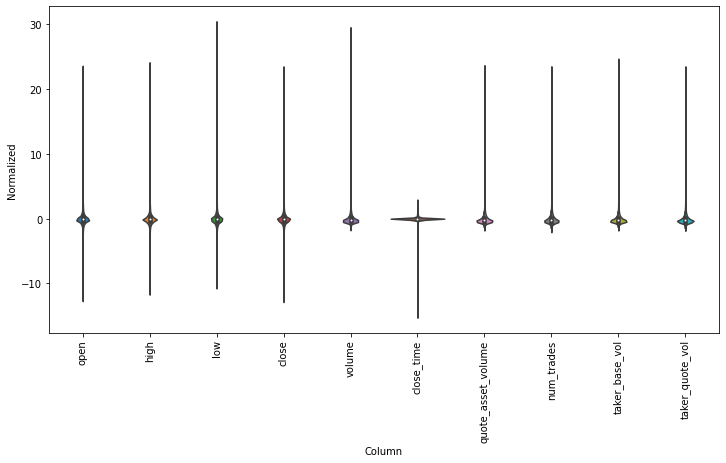

In [12]:

import numpy as np

def train_test(df):
    

    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std

    df_std = (df - train_mean) / train_std
    df_std = df_std.melt(var_name='Column', value_name='Normalized')
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
    _ = ax.set_xticklabels(df.keys(), rotation=90)
    return train_df , val_df , test_df



test = train_test(df)[0]

def compile_and_fit(model, window, patience=2):
  MAX_EPOCHS = 20

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history
test.describe()

In [61]:
df.describe()

,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol
count,41881.000000,41881.000000,41881.000000,41881.000000,41881.000000,41881.000000,41881.000000,41881.000000,41881.000000,41881.000000
mean,1.444381,1.425230,1.408129,1.443281,0.333744,20.735876,0.346280,0.342009,0.319761,0.331377
std,17.574148,17.229821,17.293325,17.590660,2.365384,0.377528,2.267502,2.211759,2.276931,2.209267
min,-204.206451,-188.062915,-159.173092,-206.880625,-3.537065,13.931688,-3.413388,-3.949557,-3.496084,-3.441360
25%,-4.151866,-4.194359,-3.933994,-4.150763,-0.734684,20.730607,-0.732067,-0.766968,-0.737964,-0.737603
50%,0.440970,0.360483,0.504483,0.441034,-0.272509,20.730607,-0.264180,-0.225523,-0.267073,-0.264538
75%,5.817907,5.809910,5.685984,5.813438,0.611173,20.730607,0.642958,0.727131,0.608765,0.635127
max,388.260234,398.318544,466.082784,387.618326,73.805924,21.980123,56.181393,54.468408,59.038417,54.118235


In [13]:
#variables_used = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume','num_trades','taker_base_vol','taker_quote_vol' ]
variables_used = ['close']

2023-03-24 14:23:31.597381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-24 14:23:31.597400: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-24 14:23:31.597414: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alice-GF63-Thin-9SCSR): /proc/driver/nvidia/version does not exist
2023-03-24 14:23:31.598002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


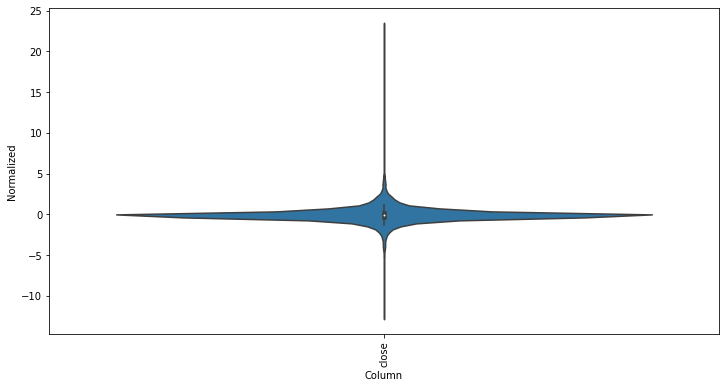

In [14]:
train_df, val_df, test_df = train_test(df[variables_used])

wide_window = WindowGenerator(
        input_width=imput_width, label_width=label_width, shift=0,
        label_columns=["close"] , train_df=train_df, val_df=val_df, test_df=test_df )

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_shape=(imput_width, len(variables_used))),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(label_width)
])

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, -48:-24, self.label_index]
    return result[:, :, tf.newaxis]

column_indices = {name: i for i, name in enumerate(df.columns)}

baseline = Baseline(label_index=column_indices['close'])
LSTM =  tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(imput_width,  len(variables_used))),
    tf.keras.layers.Dense(label_width)
])

Conv1D = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(imput_width,  len(variables_used))),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(label_width)
])


models = [ 
  # baseline , 
 
  dense , LSTM , Conv1D]


In [16]:

val_performance={}
performance={}
for model in [models[1]]:
        history = compile_and_fit(model, wide_window)

        val_performance[f"{model.name}"] = model.evaluate(wide_window.val)
        performance[f"{model.name}"] = model.evaluate(wide_window.test, verbose=0)


Epoch 1/20
912/912 [==============================] - 47s 50ms/step - loss: 0.1333 - mean_absolute_error: 0.1451 - val_loss: 0.0217 - val_mean_absolute_error: 0.0953
Epoch 2/20
912/912 [==============================] - 45s 49ms/step - loss: 0.0403 - mean_absolute_error: 0.0910 - val_loss: 0.0133 - val_mean_absolute_error: 0.0712
Epoch 3/20
912/912 [==============================] - 45s 50ms/step - loss: 0.0276 - mean_absolute_error: 0.0766 - val_loss: 0.0073 - val_mean_absolute_error: 0.0491
Epoch 4/20
912/912 [==============================] - 48s 53ms/step - loss: 0.0203 - mean_absolute_error: 0.0676 - val_loss: 0.0059 - val_mean_absolute_error: 0.0440
Epoch 5/20
912/912 [==============================] - 48s 53ms/step - loss: 0.0199 - mean_absolute_error: 0.0649 - val_loss: 0.0055 - val_mean_absolute_error: 0.0440
Epoch 6/20
912/912 [==============================] - 47s 52ms/step - loss: 0.0139 - mean_absolute_error: 0.0560 - val_loss: 0.0047 - val_mean_absolute_error: 0.0403
Epoc

In [82]:
performance


{'sequential_15': [0.00447112089022994, 0.02865179069340229],
 'sequential_16': [1.3842569589614868, 0.18737848103046417],
 'sequential_17': [0.15527217090129852, 0.17196621000766754]}

In [17]:
data_pred = get_binance_data('BTCUSDT', Client.KLINE_INTERVAL_1HOUR, '1 Mar 2023', '24 Mar 2023')


KeyboardInterrupt: 

In [18]:
df_pred = pd.DataFrame(data_pred , columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'quote_asset_volume','num_trades','taker_base_vol','taker_quote_vol', 'ignore'] )
df_pred['open_time'] = pd.to_datetime(df_pred['open_time'])
df_pred.set_index('open_time', inplace=True)
df_pred = df_pred.astype(float)
df_pred.head()


,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol,ignore
open_time,,,,,,,,,,,
1970-01-01 00:27:57.628800,23141.57,23219.99,23020.03,23101.00,12736.94918,1.677632e+12,2.946088e+08,430193.0,6319.19996,1.461616e+08,0.0
1970-01-01 00:27:57.632400,23101.00,23296.94,23075.14,23245.96,11574.17720,1.677636e+12,2.684089e+08,406084.0,5870.16685,1.361318e+08,0.0
1970-01-01 00:27:57.636000,23245.96,23336.46,23234.20,23331.21,7905.82139,1.677640e+12,1.840239e+08,347380.0,4005.83436,9.324660e+07,0.0
1970-01-01 00:27:57.639600,23332.57,23498.00,23305.97,23441.14,14946.69431,1.677643e+12,3.500738e+08,475232.0,7761.09682,1.817791e+08,0.0
1970-01-01 00:27:57.643200,23440.37,23847.00,23425.44,23794.48,15445.26401,1.677647e+12,3.647411e+08,492077.0,8443.33167,1.994118e+08,0.0


In [36]:
df_pred

,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol,ignore
0,23141.57,23219.99,23020.03,23101.00,12736.94918,1.677632e+12,2.946088e+08,430193.0,6319.19996,1.461616e+08,0.0
1,23101.00,23296.94,23075.14,23245.96,11574.17720,1.677636e+12,2.684089e+08,406084.0,5870.16685,1.361318e+08,0.0
2,23245.96,23336.46,23234.20,23331.21,7905.82139,1.677640e+12,1.840239e+08,347380.0,4005.83436,9.324660e+07,0.0
3,23332.57,23498.00,23305.97,23441.14,14946.69431,1.677643e+12,3.500738e+08,475232.0,7761.09682,1.817791e+08,0.0
4,23440.37,23847.00,23425.44,23794.48,15445.26401,1.677647e+12,3.647411e+08,492077.0,8443.33167,1.994118e+08,0.0
...,...,...,...,...,...,...,...,...,...,...,...
548,28369.82,28371.92,28096.60,28280.03,4652.98435,1.679605e+12,1.312611e+08,81447.0,2397.54537,6.763083e+07,0.0
549,28280.03,28280.03,27967.93,28163.79,2840.11442,1.679609e+12,7.989510e+07,72984.0,1293.26133,3.637930e+07,0.0
550,28163.80,28265.17,28087.93,28214.10,2872.38103,1.679612e+12,8.093029e+07,45114.0,1541.77574,4.344221e+07,0.0
551,28214.10,28438.00,28186.74,28295.41,3912.16840,1.679616e+12,1.108639e+08,60544.0,2148.13546,6.087096e+07,0.0


In [19]:
def normalize(df_pred):
    df_back = df_pred[variables_used]
    for value in df_back:
        rolling_mean = df_back[value].shift(imput_width).rolling(window=30).mean()
        rolling_std = df_back[value].shift(imput_width).rolling(window=30).std()
        df_back[value] = (df_back[value] - rolling_mean) / rolling_std

    
    
    
    

    train_mean = train_df.mean()
    train_std = train_df.std()

    df_back  = (df_back - train_mean) / train_std
    return df_back

      


In [20]:
df_pred_norm = normalize(df_pred).dropna()
df_pred_norm

/tmp/ipykernel_9471/175954608.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_back[value] = (df_back[value] - rolling_mean) / rolling_std


,close
open_time,
1970-01-01 00:27:58.338000,-10.358432
1970-01-01 00:27:58.341600,-11.913206
1970-01-01 00:27:58.345200,-13.078176
1970-01-01 00:27:58.348800,-13.707567
1970-01-01 00:27:58.352400,-13.798757
...,...
1970-01-01 00:27:59.601600,15.115283
1970-01-01 00:27:59.605200,14.080010
1970-01-01 00:27:59.608800,14.325229


In [134]:
train_std

,close
open_time,
1970-01-01 00:25:28.520400,0.075758
1970-01-01 00:25:28.524000,0.061761
1970-01-01 00:25:28.527600,0.019632
1970-01-01 00:25:28.531200,-0.027240
1970-01-01 00:25:28.534800,-0.019911
...,...
1970-01-01 00:27:14.353200,0.728160
1970-01-01 00:27:14.356800,0.744747
1970-01-01 00:27:14.360400,0.810474


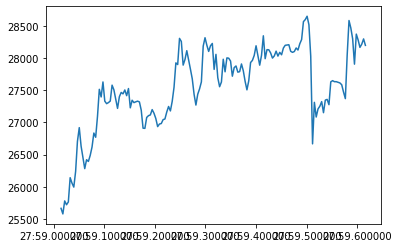

In [140]:
import matplotlib.pyplot as plt

plt.plot(df_pred["close"].tail(imput_width))
# display the plot
plt.show()

In [21]:
 
def data_for_prediction_parser( df):
  data = np.array(df [variables_used].tail(imput_width), dtype=np.float32)
  print(  data)
  return data .reshape((1, imput_width, len( variables_used)))


In [87]:
data_for_prediction = data_for_prediction_parser(df_pred_norm)

[[ 6.816987 ]
 [ 6.4963794]
 [ 6.6658893]
 [ 6.3565454]
 [ 6.2916365]
 [ 6.668902 ]
 [ 6.5097146]
 [ 6.4457197]
 [ 6.7759995]
 [ 7.328543 ]
 [ 7.6645756]
 [ 7.485578 ]
 [ 7.507882 ]
 [ 7.500215 ]
 [ 7.9844837]
 [ 8.333096 ]
 [ 8.958969 ]
 [ 9.721237 ]
 [11.039897 ]
 [12.377374 ]
 [15.221384 ]
 [19.385914 ]
 [25.808668 ]
 [33.91047  ]
 [37.699608 ]
 [34.44696  ]
 [33.33906  ]
 [33.47571  ]
 [34.372696 ]
 [33.452343 ]
 [32.391457 ]
 [31.754246 ]
 [32.533463 ]
 [33.17324  ]
 [33.11362  ]
 [33.78636  ]
 [33.531822 ]
 [34.16607  ]
 [33.39752  ]
 [37.135086 ]
 [38.705963 ]
 [39.2      ]
 [39.14021  ]
 [40.135258 ]
 [38.95046  ]
 [37.19464  ]
 [36.756588 ]
 [38.673805 ]
 [38.59855  ]
 [39.514652 ]
 [40.083748 ]
 [39.772366 ]
 [39.288166 ]
 [38.477177 ]
 [41.179745 ]
 [42.41976  ]
 [42.899006 ]
 [42.290768 ]
 [42.453735 ]
 [42.557568 ]
 [47.13152  ]
 [49.727577 ]
 [52.777126 ]
 [58.825584 ]
 [50.493233 ]
 [41.049103 ]
 [39.35276  ]
 [29.962471 ]
 [26.464462 ]
 [21.442404 ]
 [16.764267 ]
 [12.9

In [88]:
std = train_df.std()["close"]
mean = train_df["close"].mean()
std , mean

(1.0, -7.752784896454993e-18)

In [145]:
test_df.tail()["close"]

open_time
1970-01-01 00:27:59.587200    0.854572
1970-01-01 00:27:59.590800    0.820512
1970-01-01 00:27:59.594400    0.724200
1970-01-01 00:27:59.598000    0.808156
1970-01-01 00:27:59.601600    0.787141
Name: close, dtype: float64

In [89]:

prediction = models[0].predict(data_for_prediction)[0]
normalized_prediction = pd.DataFrame(prediction, columns=["predictions"] ) 
predictions_no_ma = pd.DataFrame( (std*(normalized_prediction)) + mean)
predictions_no_ma


1/1 [==============================] - 0s 14ms/step


,predictions
0,-3.860098
1,1.851751
2,-4.229986
3,0.905960
4,-6.552296
5,-7.693676
6,-4.201727
7,5.205452
8,-6.749799
9,0.826365


In [ ]:
 df_pred[variables_used].shift(imput_width)

In [90]:
rolling_mean = df_pred[variables_used].shift(imput_width).rolling(window=30).mean()
rolling_std = df_pred[variables_used].shift(imput_width).rolling(window=30).std()
rolling_mean ,rolling_std

(            close
 0             NaN
 1             NaN
 2             NaN
 3             NaN
 4             NaN
 ..            ...
 548  24538.365667
 549  24553.132333
 550  24582.362333
 551  24606.259667
 552  24623.222667
 
 [553 rows x 1 columns],
           close
 0           NaN
 1           NaN
 2           NaN
 3           NaN
 4           NaN
 ..          ...
 548  247.541793
 549  256.438571
 550  253.520396
 551  257.967834
 552  261.276635
 
 [553 rows x 1 columns])

In [75]:
rolling_std.iloc[ -label_width:].reset_index().drop("index", axis =1 )


,close
0,221.977494
1,225.290060
2,231.871335
3,236.342720
4,237.813193
5,235.278239
6,224.869839
7,217.506976
8,215.804940
9,223.092769


In [91]:
prediction_ = predictions_no_ma["predictions"]  *rolling_std.iloc[ -label_width:].reset_index().drop("index", axis =1 )["close"]  + rolling_mean.tail(label_width).reset_index().drop("index", axis =1 )["close"]
prediction_

0     23716.525759
1     24983.647862
2     23576.636788
3     24757.041765
4     22973.781864
5     22716.805907
6     23572.394011
7     25641.231554
8     23050.388078
9     24695.728401
10    23766.749657
11    24154.320647
12    24650.429951
13    24569.981337
14    26805.869814
15    26581.222291
16    23422.819562
17    24560.283783
18    25664.034834
19    26062.749274
20    24492.435368
21    27363.501697
22    25750.434945
23    23823.612522
dtype: float64

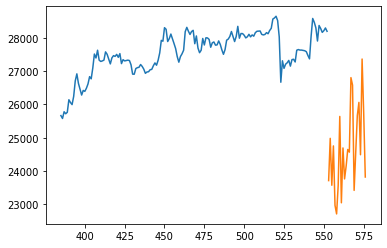

In [108]:

df_pred.reset_index(inplace=True , drop=True) 
prediction__ = pd.DataFrame(prediction_)
prediction__.index = prediction__.index.map(lambda x: x + df_pred.shape[0])

plt.plot(df_pred["close"].tail(imput_width))
# display the plot
plt.plot( prediction__ )



plt.show()

In [110]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


In [6]:
bitcoin_data = data
df = pd.DataFrame(data , columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'quote_asset_volume','num_trades','taker_base_vol','taker_quote_vol', 'ignore'] )
df['open_time'] = pd.to_datetime(df['open_time'])
df.set_index('open_time', inplace=True)
df = df.astype(float)
df.drop( ["ignore"] , axis=1  , inplace=True)
df.head()

,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_base_vol,taker_quote_vol
open_time,,,,,,,,,,
1970-01-01 00:25:27.811200,7485.01,7538.00,7477.50,7517.84,1381.859204,1.527815e+12,1.037592e+07,8465.0,859.825064,6.456825e+06
1970-01-01 00:25:27.814800,7515.03,7515.04,7478.43,7483.99,845.777769,1.527818e+12,6.341206e+06,14282.0,492.022255,3.688720e+06
1970-01-01 00:25:27.818400,7483.99,7522.54,7480.00,7487.82,954.614574,1.527822e+12,7.162305e+06,12365.0,587.432232,4.407405e+06
1970-01-01 00:25:27.822000,7487.82,7509.99,7454.35,7495.13,978.126602,1.527826e+12,7.322881e+06,11082.0,537.670795,4.025818e+06
1970-01-01 00:25:27.825600,7495.13,7497.07,7455.48,7491.22,962.828704,1.527829e+12,7.202737e+06,14969.0,538.148326,4.026065e+06


In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

window_size = 24*7
predicionlenght = 24
rmse_list = []
arima_model = SARIMAX(df["close"].diff(), order=(2,1,10))
arima_fit = arima_model.fit()
predictions = arima_fit.forecast(steps=predicionlenght)
print(predictions)
# Iterate through windows of test data
""" for i in range(len(df) - window_size):
    # Split data into training and testing sets
    train_data = df["close"].iloc[i:i+window_size]
    test_data = df["close"].iloc[i+window_size:i+window_size+predicionlenght]
    print(train_data , test_data )
    # Fit ARIMA model to training data
    arima_model = ARIMA(train_data, order=(1,1,1))
    arima_fit = arima_model.fit()

    # Predict Bitcoin prices for test data
    predictions = arima_fit.forecast(steps=predicionlenght)
    print(predictions)

    # Calculate root mean squared error (RMSE)
    rmse = np.sqrt(mean_squared_error(test_data, predictions))

    # Add RMSE value to list
    rmse_list.append(rmse)

# Calculate average RMSE over all windows
avg_rmse = np.mean(rmse_list)

print("Average RMSE:", avg_rmse) """


/home/alice/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alice/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alice/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alice/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


42101     4.833385
42102     2.683808
42103   -10.799863
42104    14.325154
42105    -2.154795
42106    -2.599024
42107     4.118660
42108    -4.950964
42109     6.081731
42110    -3.675887
42111     1.967215
42112     2.023430
42113    -3.618877
42114     5.860290
42115    -4.611171
42116     3.765349
42117    -0.095667
42118    -1.805616
42119     4.879351
42120    -4.736051
42121     4.940660
42122    -1.958960
42123     0.187635
42124     3.342799
Name: predicted_mean, dtype: float64


/home/alice/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


' for i in range(len(df) - window_size):\n    # Split data into training and testing sets\n    train_data = df["close"].iloc[i:i+window_size]\n    test_data = df["close"].iloc[i+window_size:i+window_size+predicionlenght]\n    print(train_data , test_data )\n    # Fit ARIMA model to training data\n    arima_model = ARIMA(train_data, order=(1,1,1))\n    arima_fit = arima_model.fit()\n\n    # Predict Bitcoin prices for test data\n    predictions = arima_fit.forecast(steps=predicionlenght)\n    print(predictions)\n\n    # Calculate root mean squared error (RMSE)\n    rmse = np.sqrt(mean_squared_error(test_data, predictions))\n\n    # Add RMSE value to list\n    rmse_list.append(rmse)\n\n# Calculate average RMSE over all windows\navg_rmse = np.mean(rmse_list)\n\nprint("Average RMSE:", avg_rmse) '

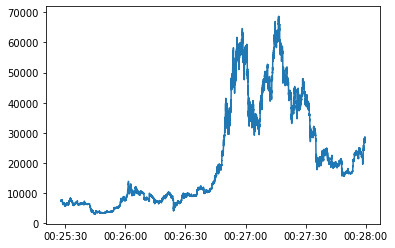

In [129]:
import matplotlib.pyplot as plt

# Plot the original time series
plt.plot(df.index, df['close'], label='Original')

# Plot the predicted values
plt.plot(predictions.index, predictions.values, label='Predicted')

# Set plot labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('ARIMA Predictions')

# Show the legend and plot
plt.legend()
plt.show()

In [23]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                42101
Model:                ARIMA(2, 1, 10)   Log Likelihood             -285929.669
Date:                Fri, 24 Mar 2023   AIC                         571885.338
Time:                        21:34:44   BIC                         571997.759
Sample:                             0   HQIC                        571920.837
                              - 42101                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6898      0.003   -600.142      0.000      -1.695      -1.684
ar.L2         -0.9830      0.003   -347.409      0.000      -0.989      -0.977
ma.L1          0.6902      0.003    199.799      0.000       0.683       0.697
ma.L2         -0.7236      0.003   -223.210      0.000      -0.730      -0.717
ma.L3         -0.9890      0.004   -232.201      0.000      -0.997      -0.981
ma.L4         -0.0131      0.004     -3.351      0.001      -0.021      -0.005
ma.L5         -0.0078      0.004     -2.044      0.041      -0.015      -0.000
ma.L6          0.0294      0.004      7.017      0.000       0.021       0.038
ma.L7          0.0343      0.004      8.751      0.000       0.027       0.042
ma.L8         -0.0108      0.003     -3.373      0.001      -0.017      -0.005
ma.L9         -0.0097      0.003     -3.510      0.000      -0.015      -0.004
ma.L10         0.0001      0.002      0.055      0.956      -0.004       0.005
sigma2      4.689e+04     90.050    520.686      0.000    4.67e+04    4.71e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1448936.36
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              17.72   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        31.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
non_stationary_data = df[["close"] ]

In [19]:
from scipy.stats import boxcox

non_stationary_data['value_diff'] = non_stationary_data["close"].diff()
non_stationary_data['value_seasonal_diff'] = non_stationary_data['close'].diff(12)
non_stationary_data['value_log'] = np.log(non_stationary_data['close'])
non_stationary_data['value_boxcox'], fitted_lambda = boxcox(non_stationary_data['close'])



/tmp/ipykernel_8114/991760935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_stationary_data['value_diff'] = non_stationary_data["close"].diff()
/tmp/ipykernel_8114/991760935.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_stationary_data['value_seasonal_diff'] = non_stationary_data['close'].diff(12)
/tmp/ipykernel_8114/991760935.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [20]:
from statsmodels.tsa.stattools import adfuller
for column in non_stationary_data.columns:
    adf_result = adfuller(non_stationary_data[column].dropna())
    print(f'ADF Statistic: {adf_result[0]} for {column}')
    print(f'p-value: {adf_result[1]}')



ADF Statistic: -1.3092747294283693 for close
p-value: 0.6249185036138085
ADF Statistic: -29.42270581200733 for value_diff
p-value: 0.0
ADF Statistic: -24.9581636610649 for value_seasonal_diff
p-value: 0.0
ADF Statistic: -0.9720612724743178 for value_log
p-value: 0.7633174550940749
ADF Statistic: -0.9668790211131959 for value_boxcox
p-value: 0.765151975502466


<Figure size 864x432 with 0 Axes>

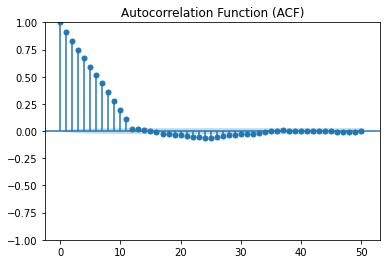

/home/alice/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x432 with 0 Axes>

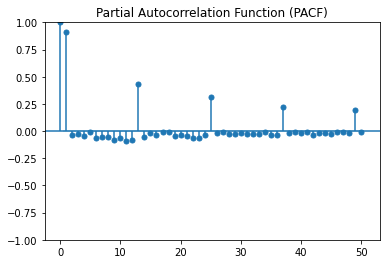

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

stationary_series = non_stationary_data['value_seasonal_diff'].dropna()
# ACF plot
plt.figure(figsize=(12, 6))
plot_acf(stationary_series, lags=50, alpha=0.05)
plt.title("Autocorrelation Function (ACF)")
plt.show()

# PACF plot
plt.figure(figsize=(12, 6))
plot_pacf(stationary_series, lags=50, alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF)")
plt.show() 
